# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/train",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/valid",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 3566 files belonging to 2 classes.
==========================Validation Data====================
Found 891 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Peach/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Peach/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3566 images belonging to 2 classes.
Found 891 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Thu May 25 14:00:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0               40W /  N/A|   4733MiB /  6144MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## DIY Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_DIY_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9254
Epoch 1: val_accuracy improved from -inf to 0.96633, saving model to Peach_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


179/179 [==============================] - 35s 173ms/step - loss: 0.2320 - accuracy: 0.9254 - val_loss: 0.1104 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9770
Epoch 2: val_accuracy improved from 0.96633 to 0.96857, saving model to Peach_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


179/179 [==============================] - 9s 49ms/step - loss: 0.0701 - accuracy: 0.9770 - val_loss: 0.0993 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9857
Epoch 3: val_accuracy did not improve from 0.96857
179/179 [==============================] - 7s 37ms/step - loss: 0.0444 - accuracy: 0.9857 - val_loss: 0.1107 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/100
178/179 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9851
Epoch 4: val_accuracy improved from 0.96857 to 0.97082, saving model to Peach_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


179/179 [==============================] - 9s 48ms/step - loss: 0.0416 - accuracy: 0.9851 - val_loss: 0.1300 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9941
Epoch 5: val_accuracy improved from 0.97082 to 0.97531, saving model to Peach_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


179/179 [==============================] - 9s 48ms/step - loss: 0.0283 - accuracy: 0.9941 - val_loss: 0.1916 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 6/100
179/179 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9882
Epoch 6: val_accuracy improved from 0.97531 to 0.97980, saving model to Peach_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


179/179 [==============================] - 9s 49ms/step - loss: 0.0326 - accuracy: 0.9882 - val_loss: 0.0933 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 7/100
179/179 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9966
Epoch 7: val_accuracy improved from 0.97980 to 0.98092, saving model to Peach_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Non_Augmented\assets


179/179 [==============================] - 10s 56ms/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 0.1278 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 8/100
178/179 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9966
Epoch 8: val_accuracy did not improve from 0.98092
179/179 [==============================] - 7s 39ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.2592 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 9/100
178/179 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9944
Epoch 9: val_accuracy did not improve from 0.98092
179/179 [==============================] - 7s 39ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.1455 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 10/100
178/179 [============================>.] - ETA: 0s - loss: 0.0242 - accuracy: 0.9929
Epoch 10: val_accuracy did not improve from 0.98092
179/179 [==============================] - 7s 39ms/step - loss: 0.0242 - accuracy: 0.9930 - val_loss: 0.1093 - val_acc

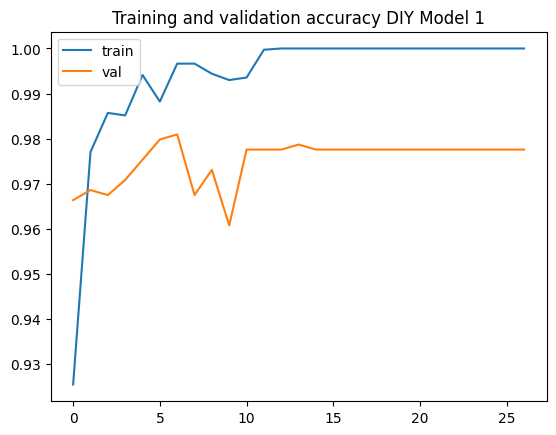

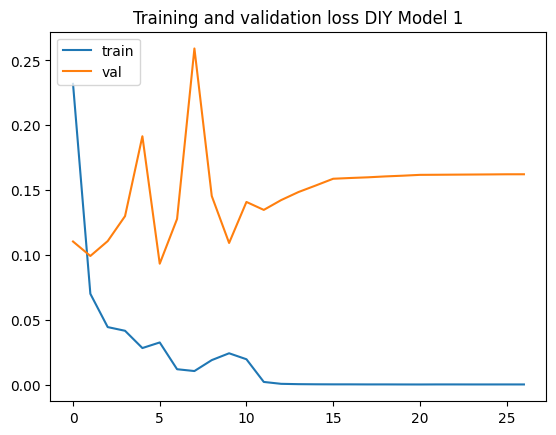

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_DIY_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.8898
Epoch 1: val_accuracy improved from -inf to 0.95735, saving model to Peach_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Non_Augmented\assets


179/179 [==============================] - 12s 62ms/step - loss: 0.3017 - accuracy: 0.8898 - val_loss: 0.1426 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9778
Epoch 2: val_accuracy improved from 0.95735 to 0.97643, saving model to Peach_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Non_Augmented\assets


179/179 [==============================] - 11s 64ms/step - loss: 0.0756 - accuracy: 0.9778 - val_loss: 0.0695 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 3/100
178/179 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9800
Epoch 3: val_accuracy did not improve from 0.97643
179/179 [==============================] - 8s 44ms/step - loss: 0.0612 - accuracy: 0.9795 - val_loss: 0.1218 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9865
Epoch 4: val_accuracy did not improve from 0.97643
179/179 [==============================] - 8s 43ms/step - loss: 0.0334 - accuracy: 0.9865 - val_loss: 0.1660 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9907
Epoch 5: val_accuracy did not improve from 0.97643
179/179 [==============================] - 8s 43ms/step - loss: 0.0341 - accuracy: 0.9907 - val_loss: 0.1011 - val_accur

INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Non_Augmented\assets


179/179 [==============================] - 11s 64ms/step - loss: 0.0218 - accuracy: 0.9944 - val_loss: 0.1245 - val_accuracy: 0.9787 - lr: 1.0000e-04
Epoch 9/100
179/179 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994
Epoch 9: val_accuracy improved from 0.97868 to 0.98316, saving model to Peach_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Non_Augmented\assets


179/179 [==============================] - 11s 63ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.1386 - val_accuracy: 0.9832 - lr: 1.0000e-04
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 10: val_accuracy did not improve from 0.98316
179/179 [==============================] - 8s 43ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1585 - val_accuracy: 0.9820 - lr: 1.0000e-04
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 11: val_accuracy did not improve from 0.98316
179/179 [==============================] - 7s 42ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1712 - val_accuracy: 0.9820 - lr: 1.0000e-04
Epoch 12/100
179/179 [==============================] - ETA: 0s - loss: 5.8187e-04 - accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.98316

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
179/179 [==========

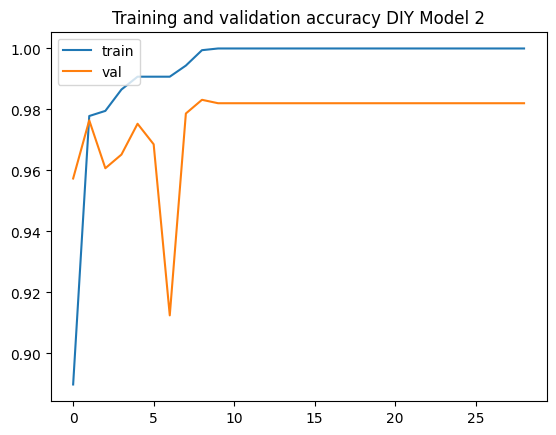

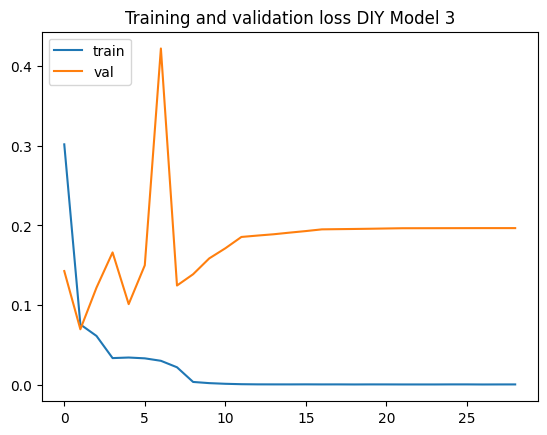

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 3')
plt.legend(['train', 'val'], loc='upper left')